In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
import os
from scipy.optimize import minimize
from scipy.stats import norm

import electricPotentialEnergy as pe

plt.rcParams['figure.dpi'] = 300

### Initialize the system

Initial Energy: 181.54863297297106


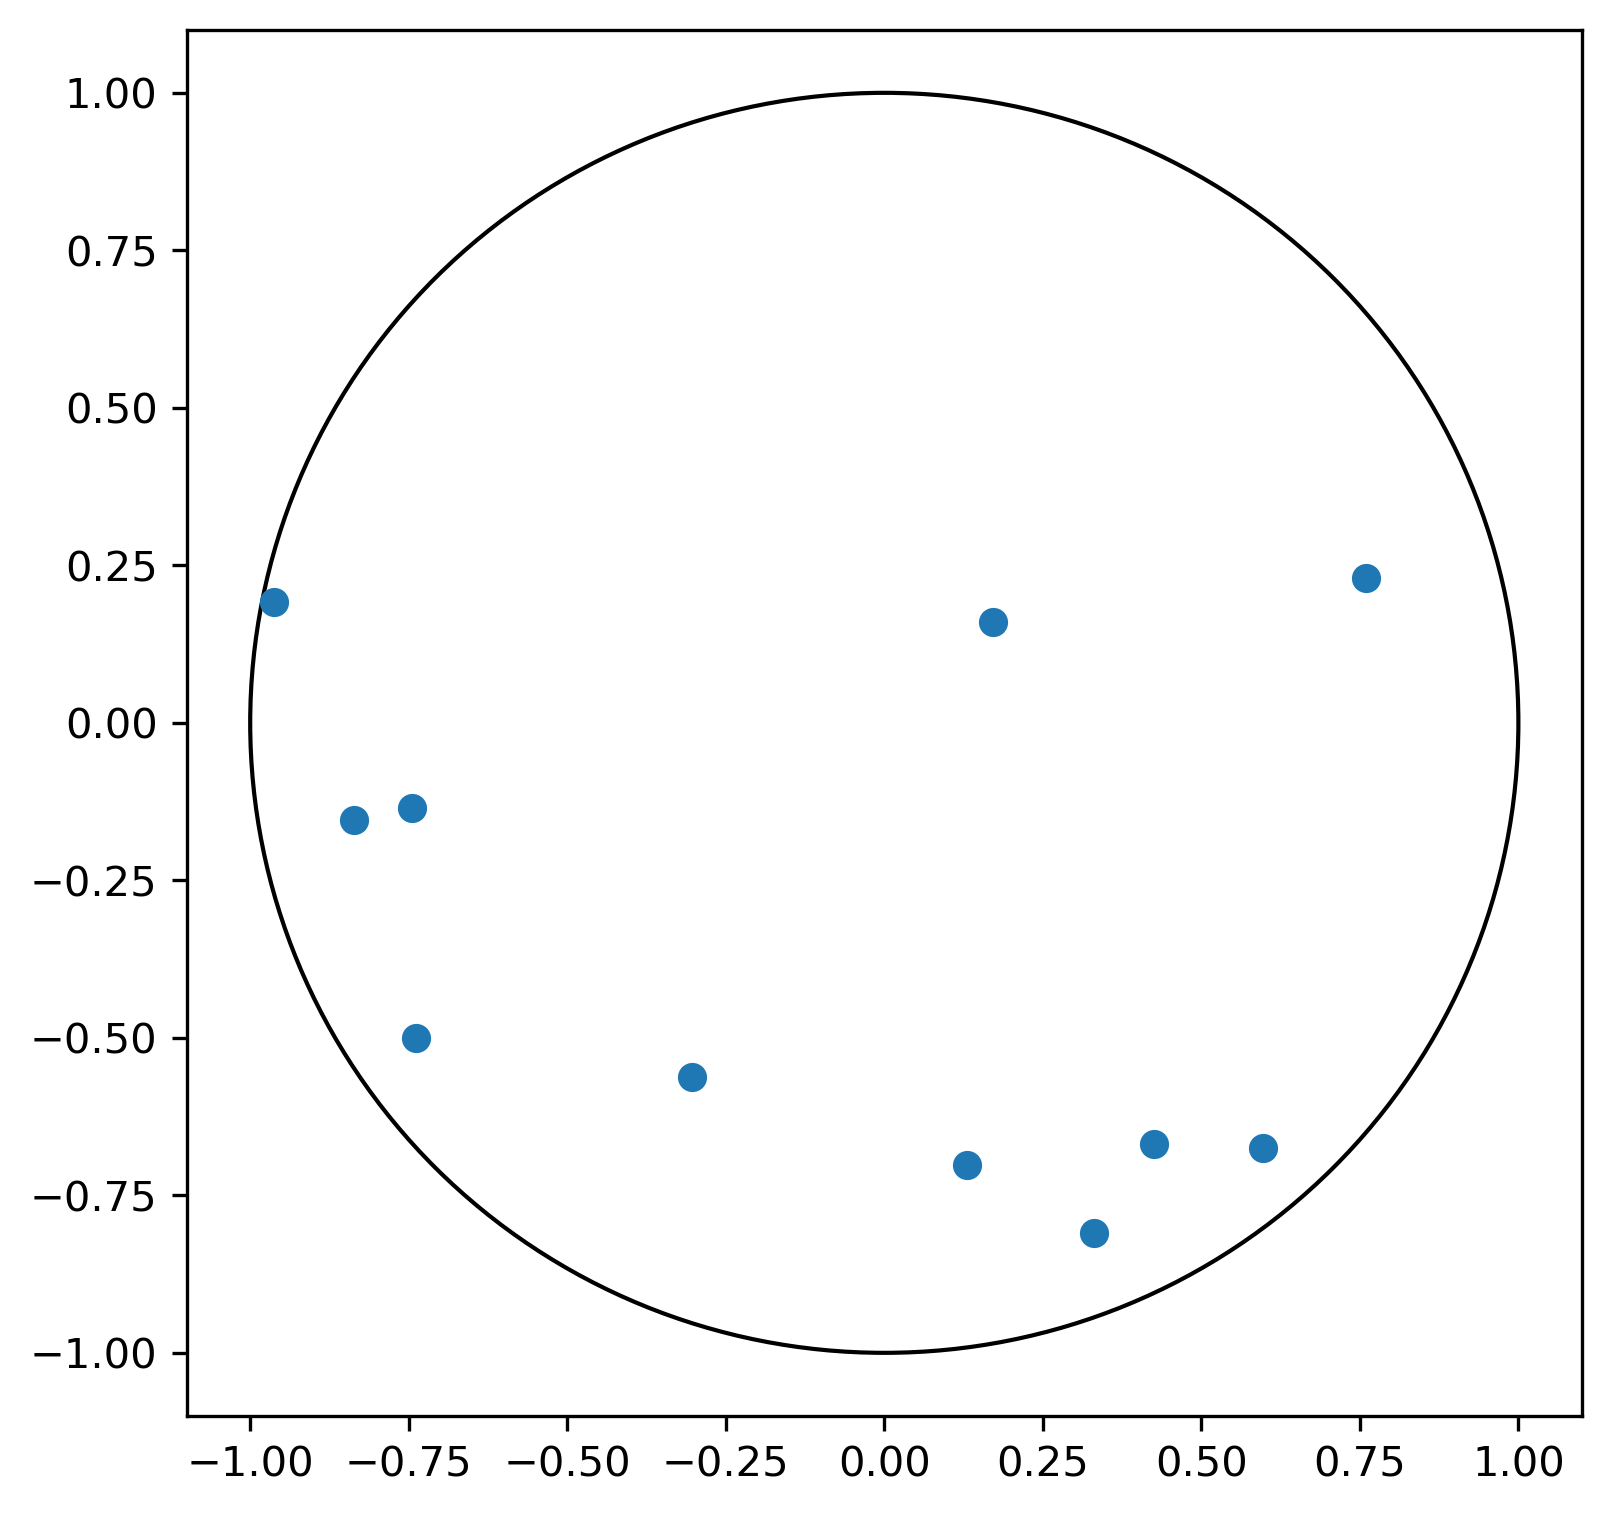

In [7]:
system = pe.Coulomb(11, seed=45)

fig, ax = pe.plotState(system.state)
print(f"Initial Energy: {system.stateEnergy()}")

### Run Simulated Annealing

/Users/Kattelijn/Desktop/stochSim3/electricPotentialEnergy.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = np.exp(-(energy_difference) / temp)


Final Energy: 97.1831176719221


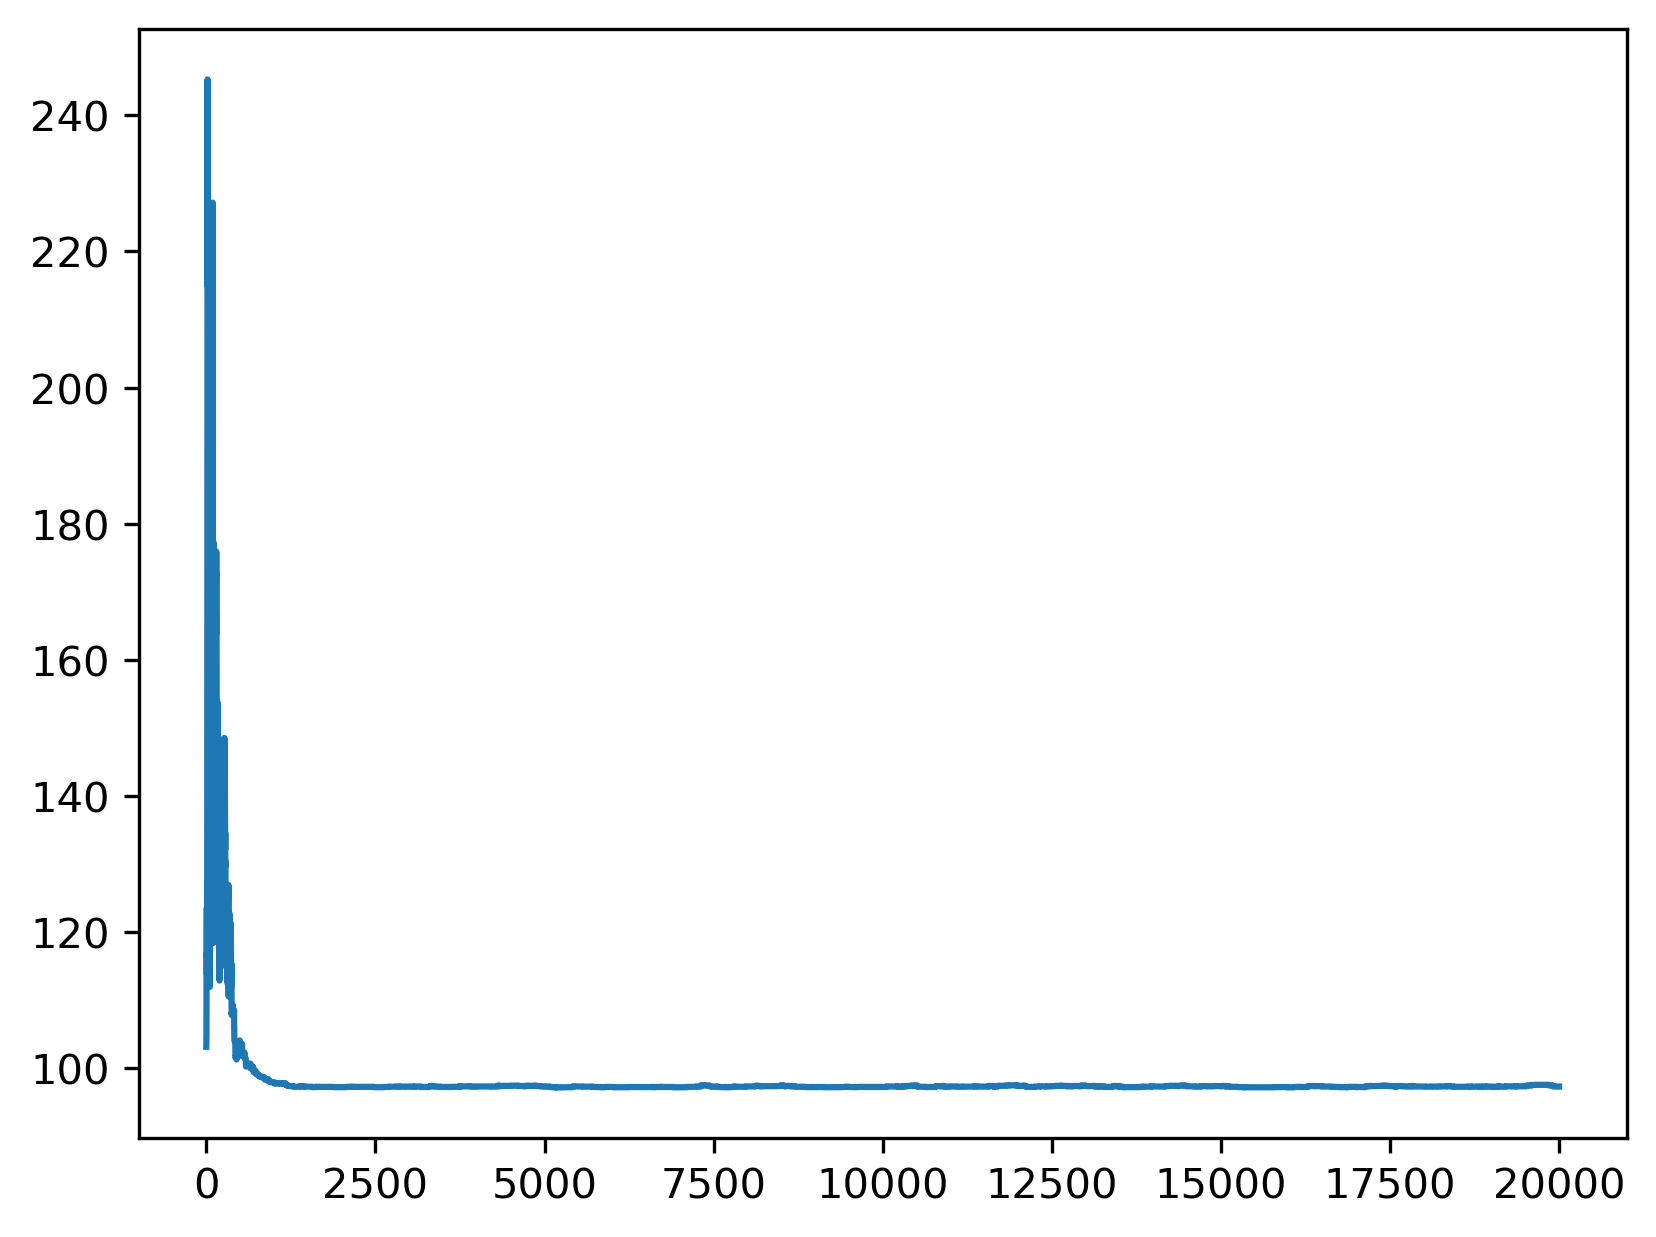

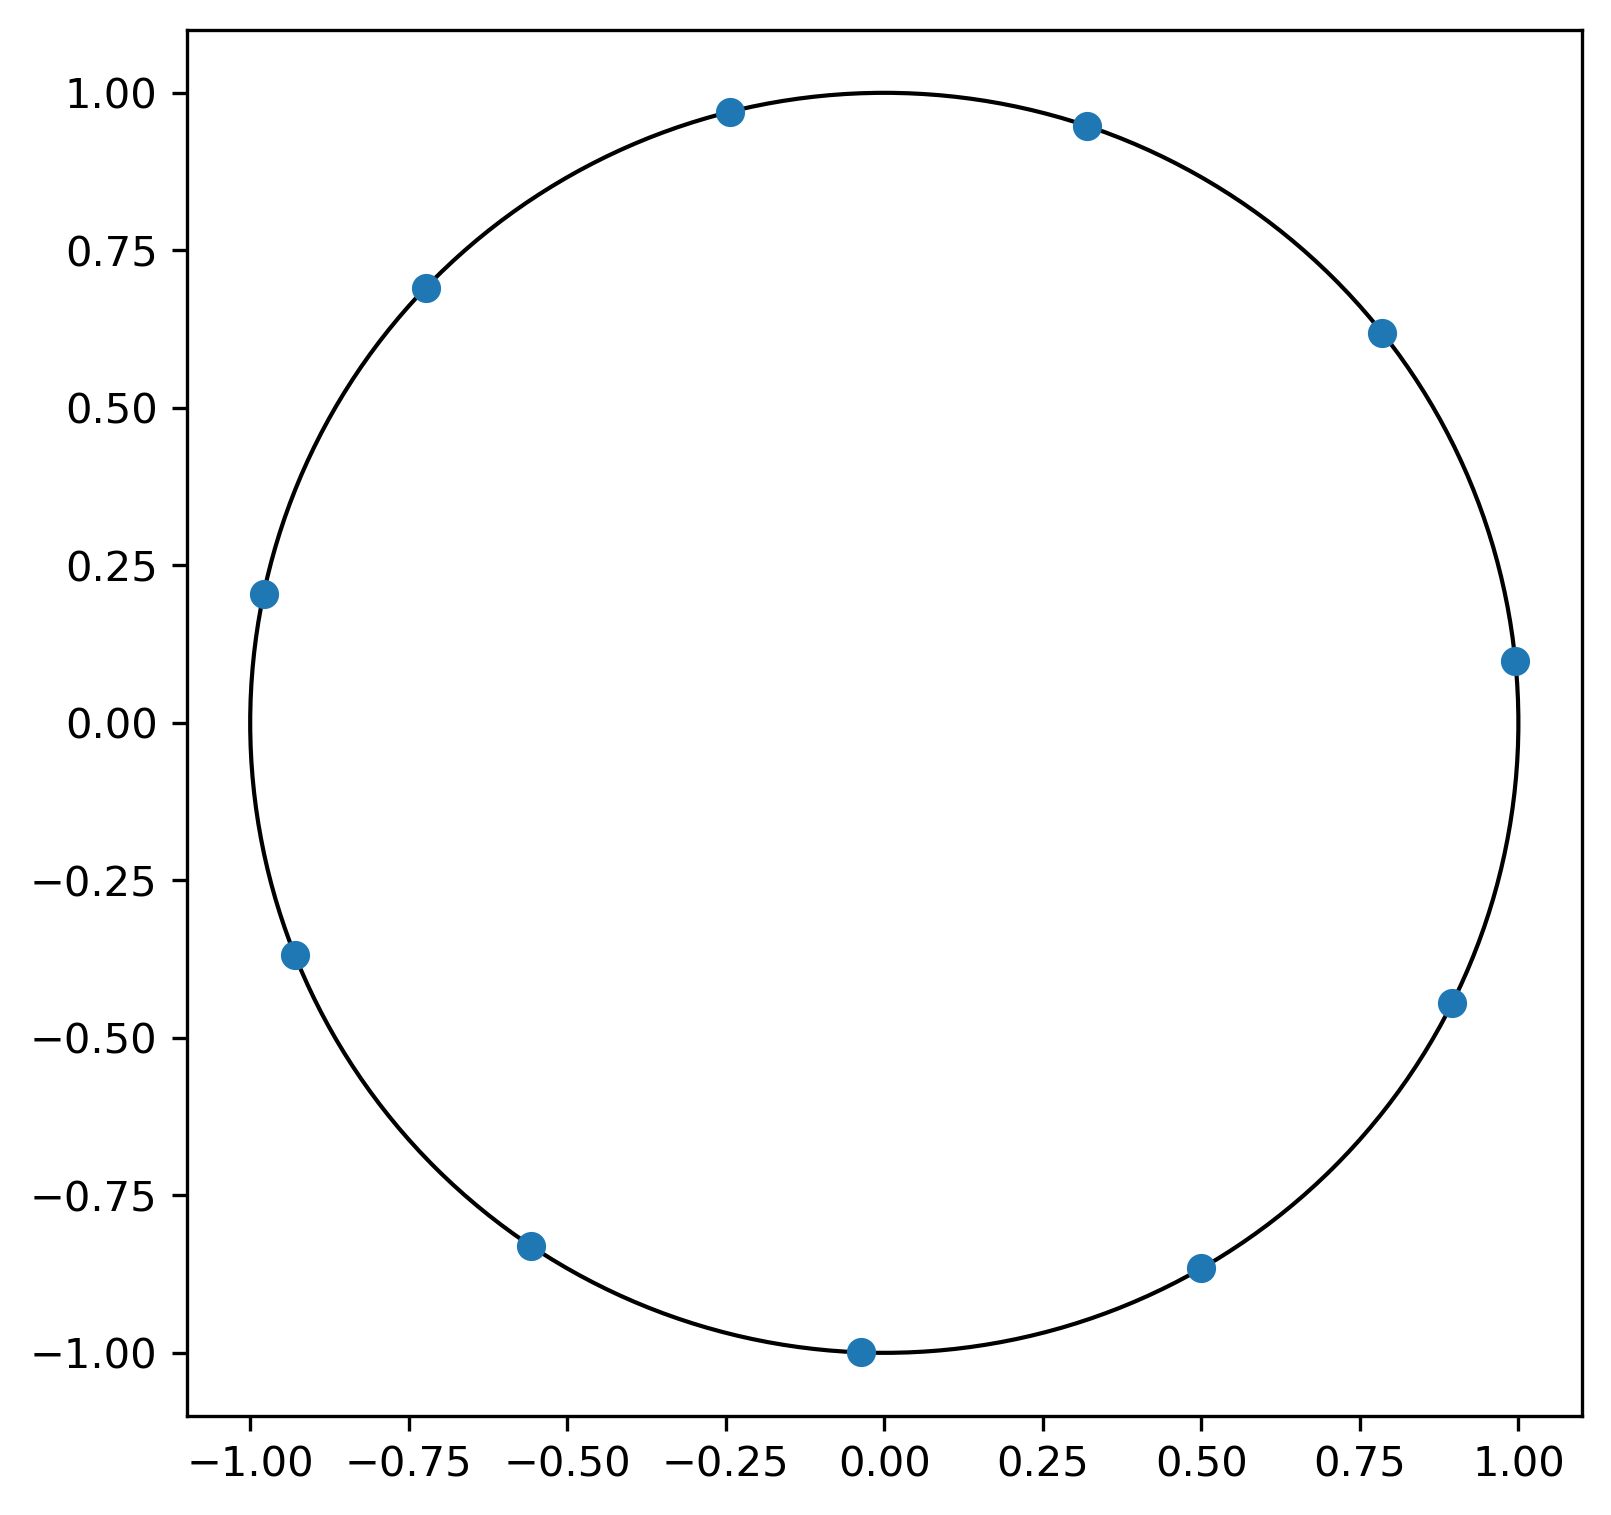

In [3]:
max_iters = 20000
initial_temp = 1e4
alpha = 0.99
max_step = 2

system = pe.Coulomb(11)
scheme = pe.arithmeticGeometric(1e2, 0.99, 3e-4)
# scheme = pe.geometricCooling(1e4, 0.99)
# scheme = pe.logarithmicCooling(1)
# scheme = pe.linearCooling(0, 1)
optimized_system, energy = pe.simulatedAnnealing(system, 1, max_iters, scheme, max_step, prerun=3000)
plt.plot(energy)

fig, ax = pe.plotState(optimized_system.state)
print(f"Final Energy: {optimized_system.stateEnergy()}")
plt.show()

In [ ]:
0/0

In [ ]:
optimum = minimize(pe.optimize,x0=[0.25, 0.25], method='Powell', bounds=[[0.1,1], [0.1,1]], options={'disp':True})

In [ ]:
print(optimum)

### Load simulation results

In [ ]:
filename = "test"

saved_states = np.load(f"{filename}_states.npy")
saved_energies = np.load(f"{filename}_energies.pny")

### Create animation using simulation results

In [ ]:
def update(frame):
    """Update function for the animation."""
    pe.plotState(saved_states[frame], animation=True, ax=ax)
    ax.set_title(f"Frame {frame+1}")

fig, ax = plt.subplots(figsize=(6, 6))
ani = animation.FuncAnimation(fig, update, frames=len(saved_states), interval=200)

ani.save(f"{filename}.mp4", fps=50)

# Markov Chain length experiments

### Energy (Single Runs)

In [123]:
n_particles = 50
max_iters = 100000
initial_temp = 100
alpha = 0.99
max_step = 2
chain_lengths = [10, 100, 1000]  # Chain lengths to experiment with

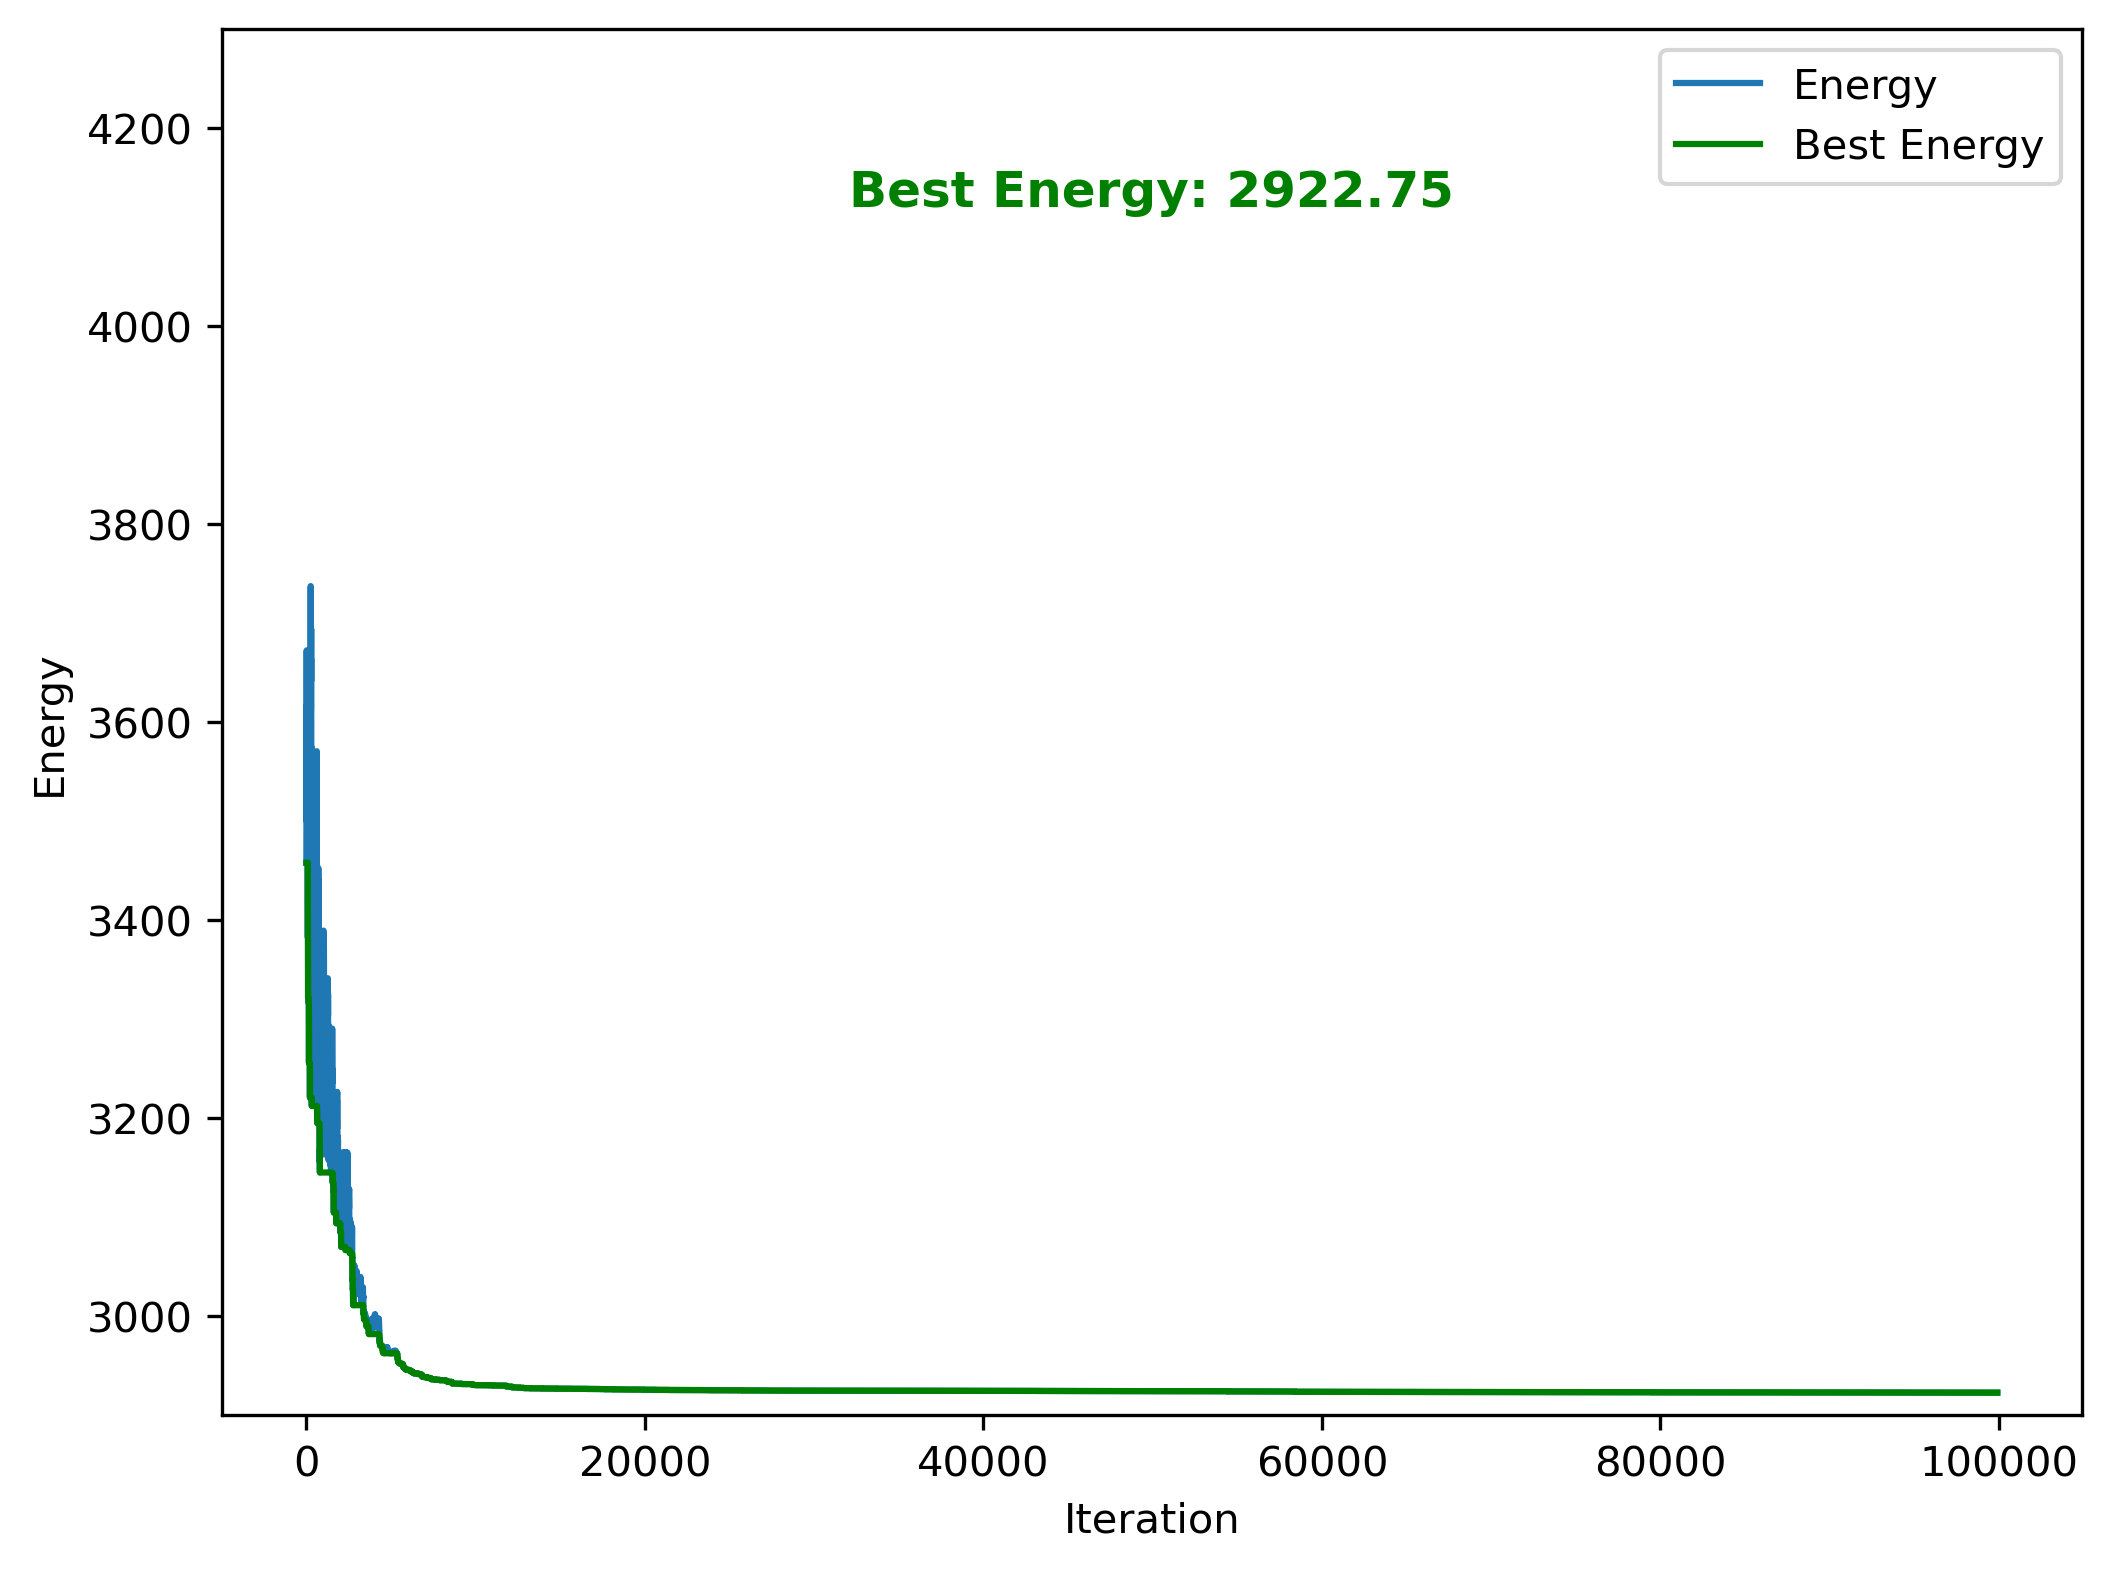

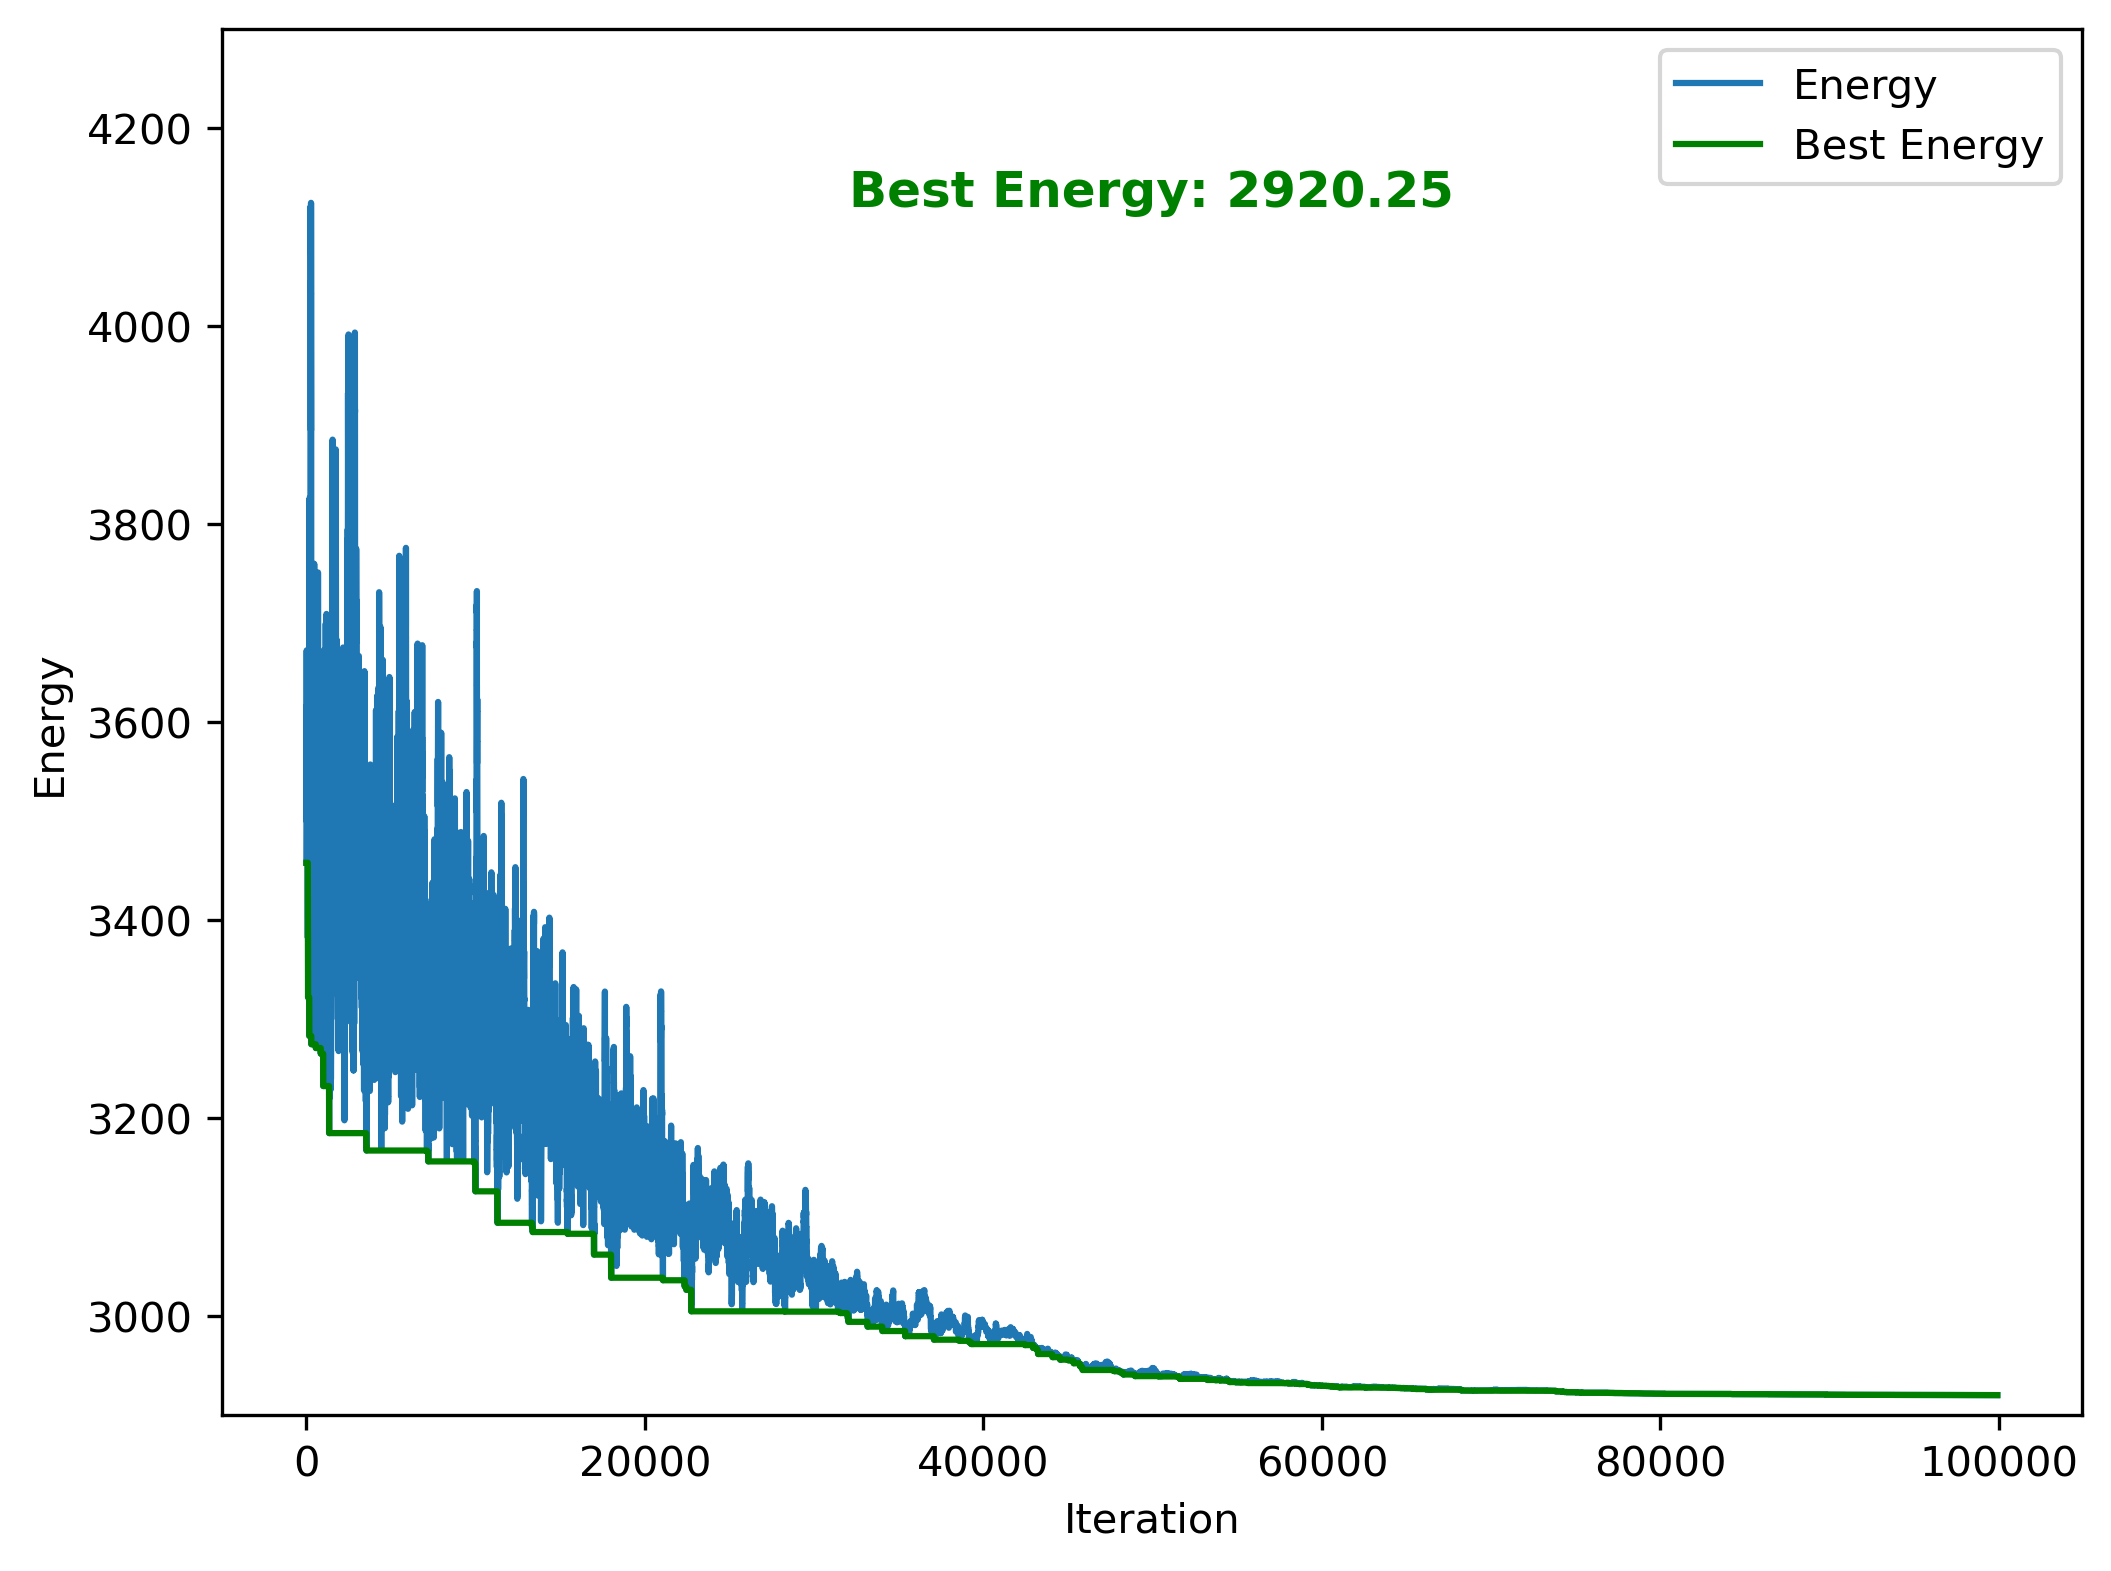

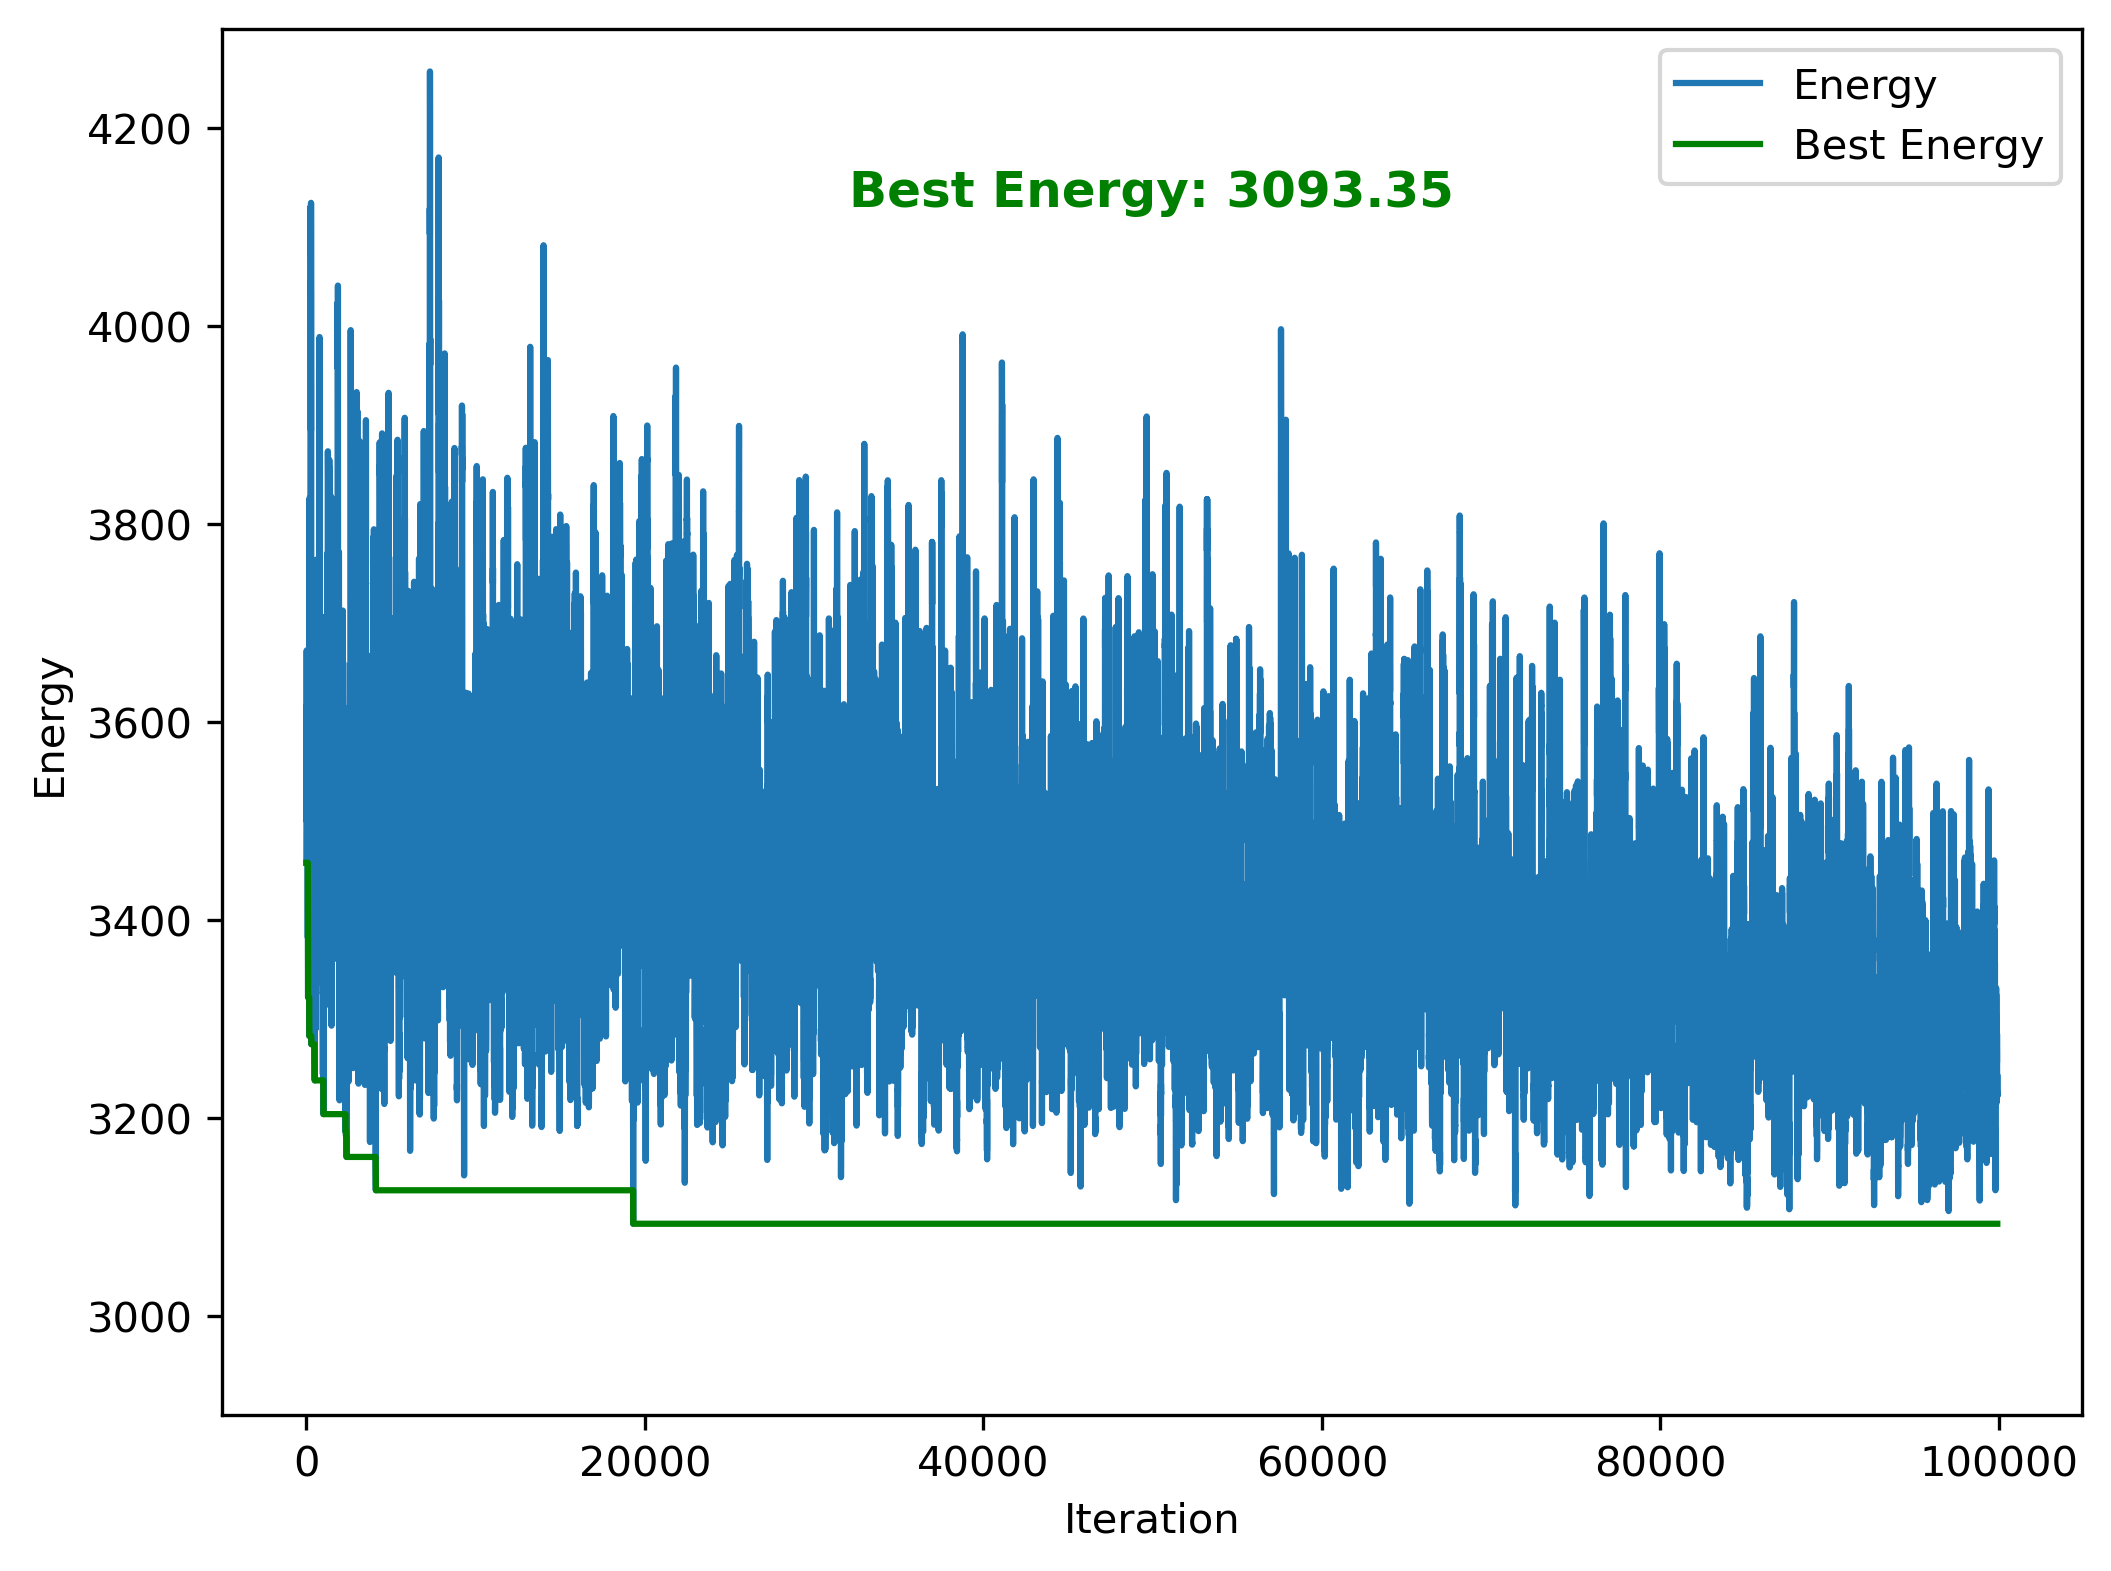

In [124]:
for j, chain_length in enumerate(chain_lengths):
    
    plt.figure(figsize=(8, 6))
        
    system = pe.Coulomb(n_particles, seed=2)
    scheme = pe.geometricCooling(initial_temp, alpha)
    optimized_system, energy = pe.simulatedAnnealing(system, chain_length, max_iters, scheme, max_step)
    best_energy = np.minimum.accumulate(energy)[-1]

    plt.plot(energy[100:-1], label="Energy")
    plt.plot(np.minimum.accumulate(energy[100:-1]), label="Best Energy", color='green')
    plt.text(0.5, 0.9, f"Best Energy: {best_energy:.2f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=12, color='green', fontweight='bold', backgroundcolor='white')
   
    plt.legend()
    plt.ylim(2900, 4300)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")

    plt.show()


## Mean Best Energy

In [9]:
n_particles = [10, 20, 50]
max_iters = 100000
initial_temp = 100
alpha = 0.99
max_step = 2
chain_lengths = [10, 100, 1000]  # Chain lengths to experiment with
repetitions = 10

parent_dir = "markov_chain_experiments"

### Run experiment

In [ ]:
# os.makedirs(parent_dir, exist_ok=True)

# for n in n_particles:  # Loop through different particle sizes
#     print(f"Running simulations for n_particles = {n}...")
    
#     particle_dir = os.path.join(parent_dir, f"n_particles_{n}")
#     os.makedirs(particle_dir, exist_ok=True)

#     for chain_length in chain_lengths:  # Loop through different chain lengths
#         print(f" Running for chain_length = {chain_length}...")

#         chain_dir = os.path.join(particle_dir, f"chain_length_{chain_length}")
#         os.makedirs(chain_dir, exist_ok=True)

#         for rep in range(repetitions):
            
#             system = pe.Coulomb(n, seed=None)  # Use a new seed for each repetition
#             scheme = pe.geometricCooling(initial_temp, alpha)
#             # scheme = pe.linearCooling(initial_temp, cooling_rate)

#             save_path = os.path.join(chain_dir, f"rep_{rep}")
#             optimized_system, _ = pe.simulatedAnnealing(system, chain_length, max_iters, scheme, max_step, save_path=save_path)


### Load results

In [10]:
results = {}

for n in n_particles:
    particle_dir = os.path.join(parent_dir, f"n_particles_{n}")
    
    particle_results = {"energies": [], "states": []}

    for chain_length in chain_lengths:
        chain_dir = os.path.join(particle_dir, f"chain_length_{chain_length}")
        
        chain_results = {"energies": [], "states": []}
        
        for rep in range(repetitions):
            states = np.load(os.path.join(chain_dir, f"rep_{rep}_states.npy"))
            energies = np.load(os.path.join(chain_dir, f"rep_{rep}_energies.npy"))
            
            chain_results["states"].append(states)
            chain_results["energies"].append(energies)
        
        particle_results[chain_length] = chain_results

    results[n] = particle_results

    print(f"Loaded results for n_particles = {n}")


Loaded results for n_particles = 10
Loaded results for n_particles = 20
Loaded results for n_particles = 50


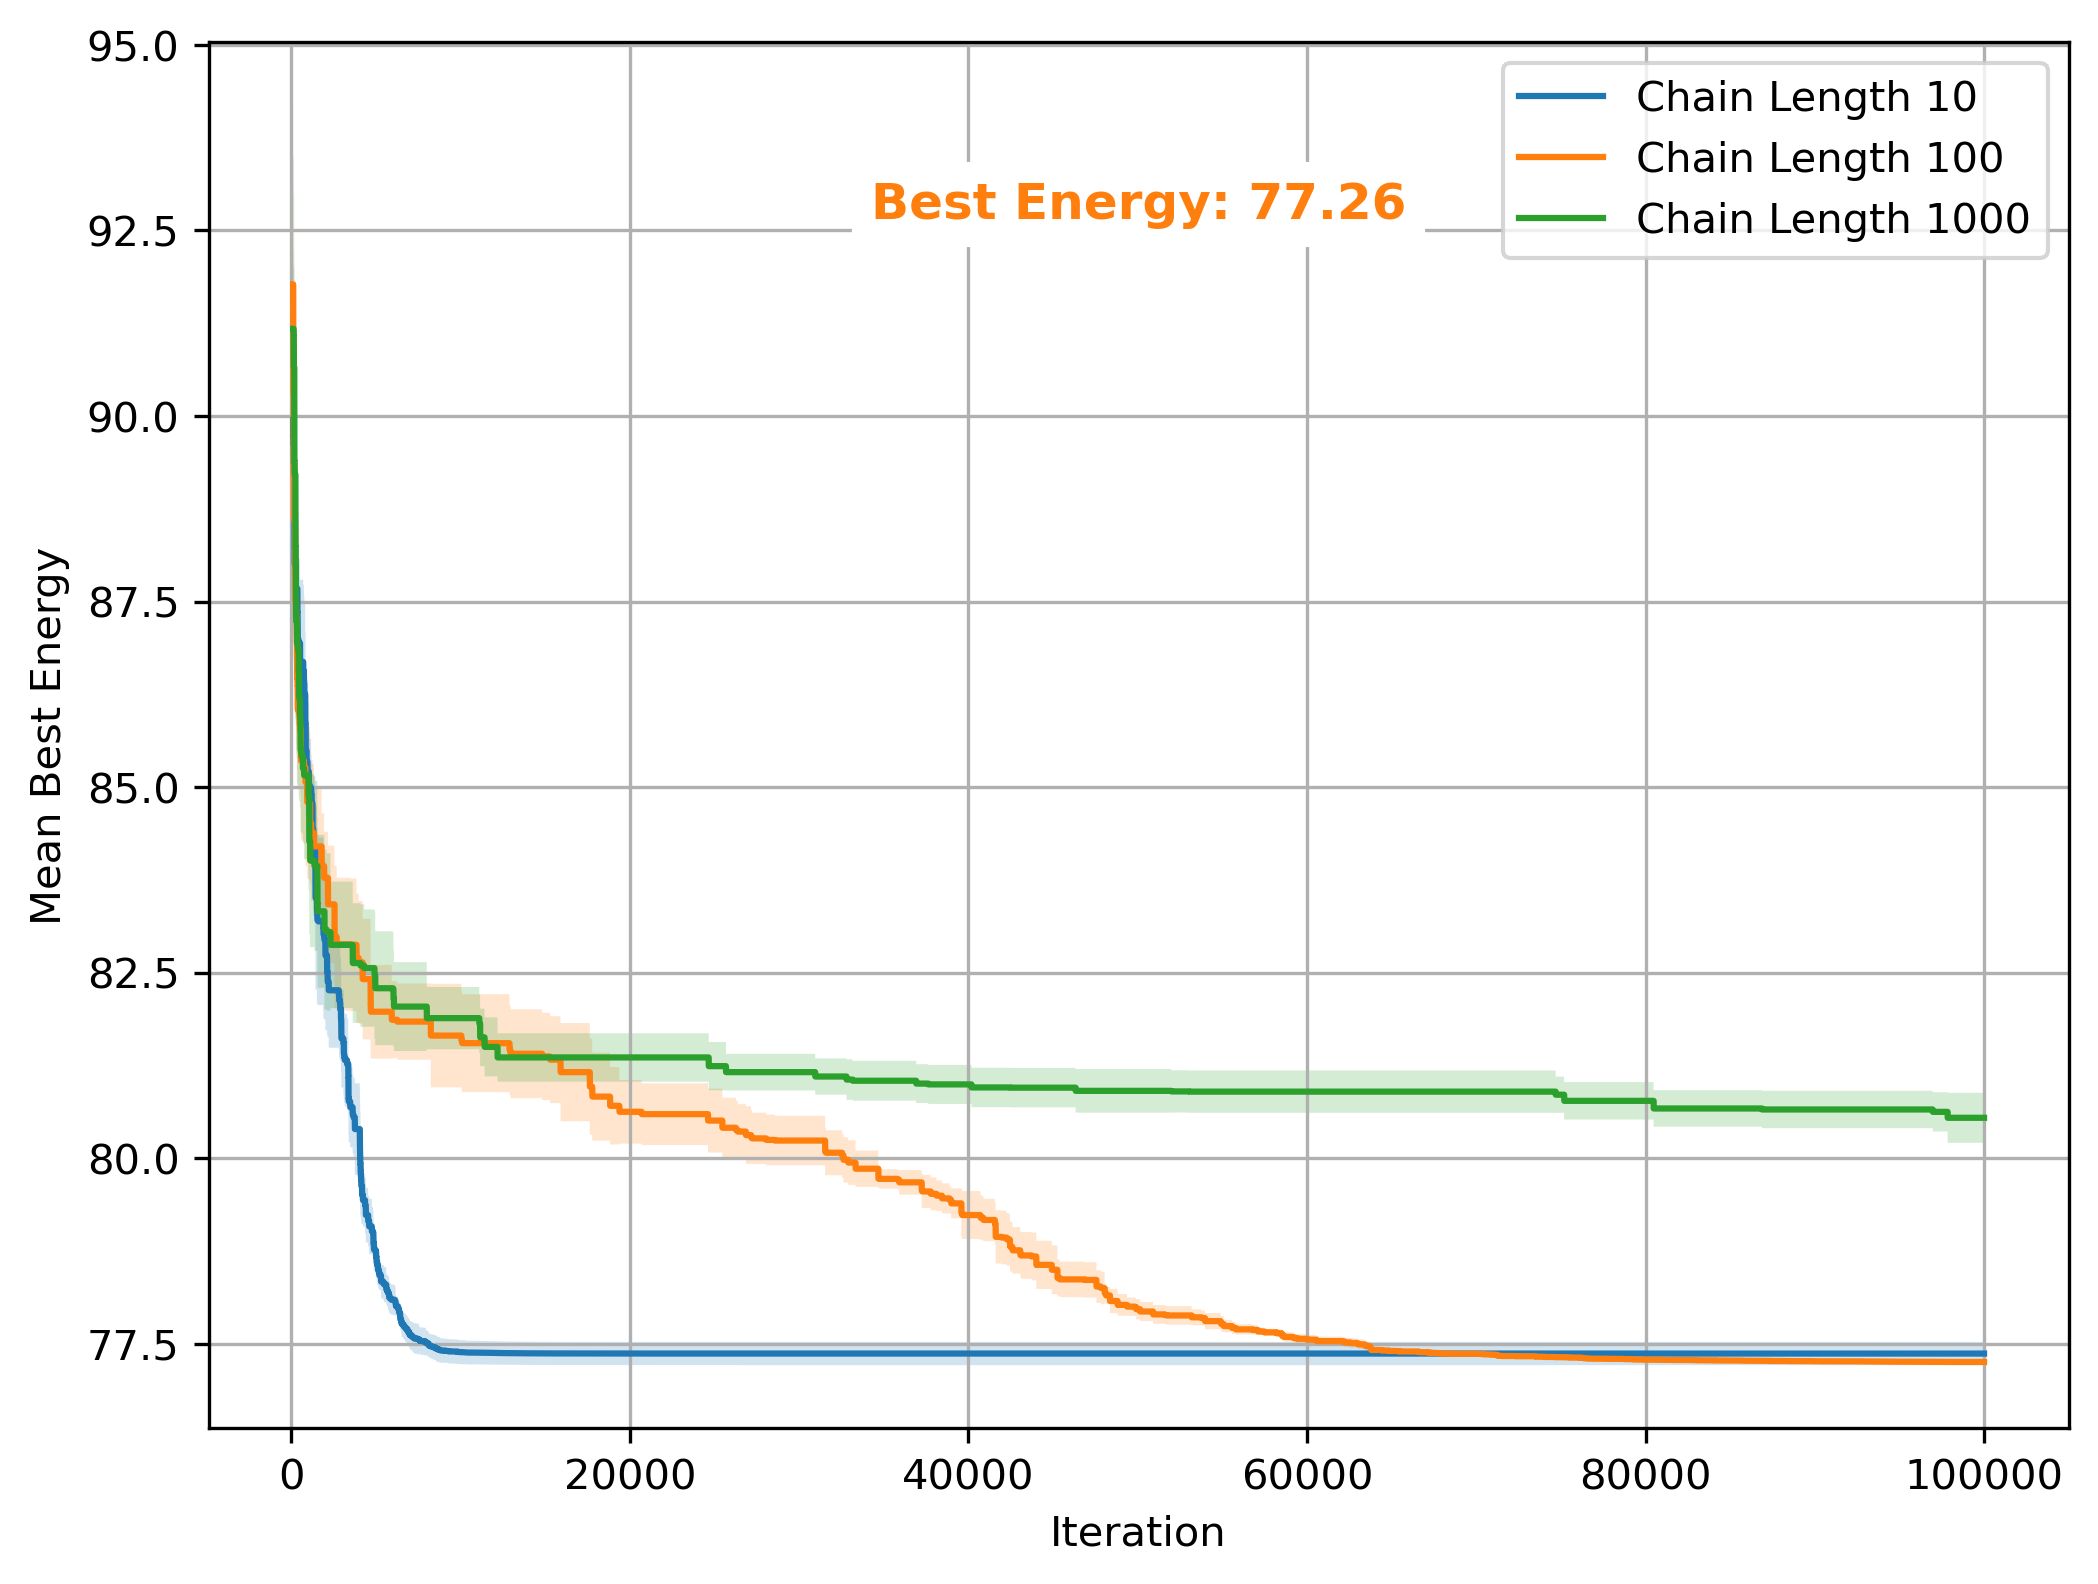

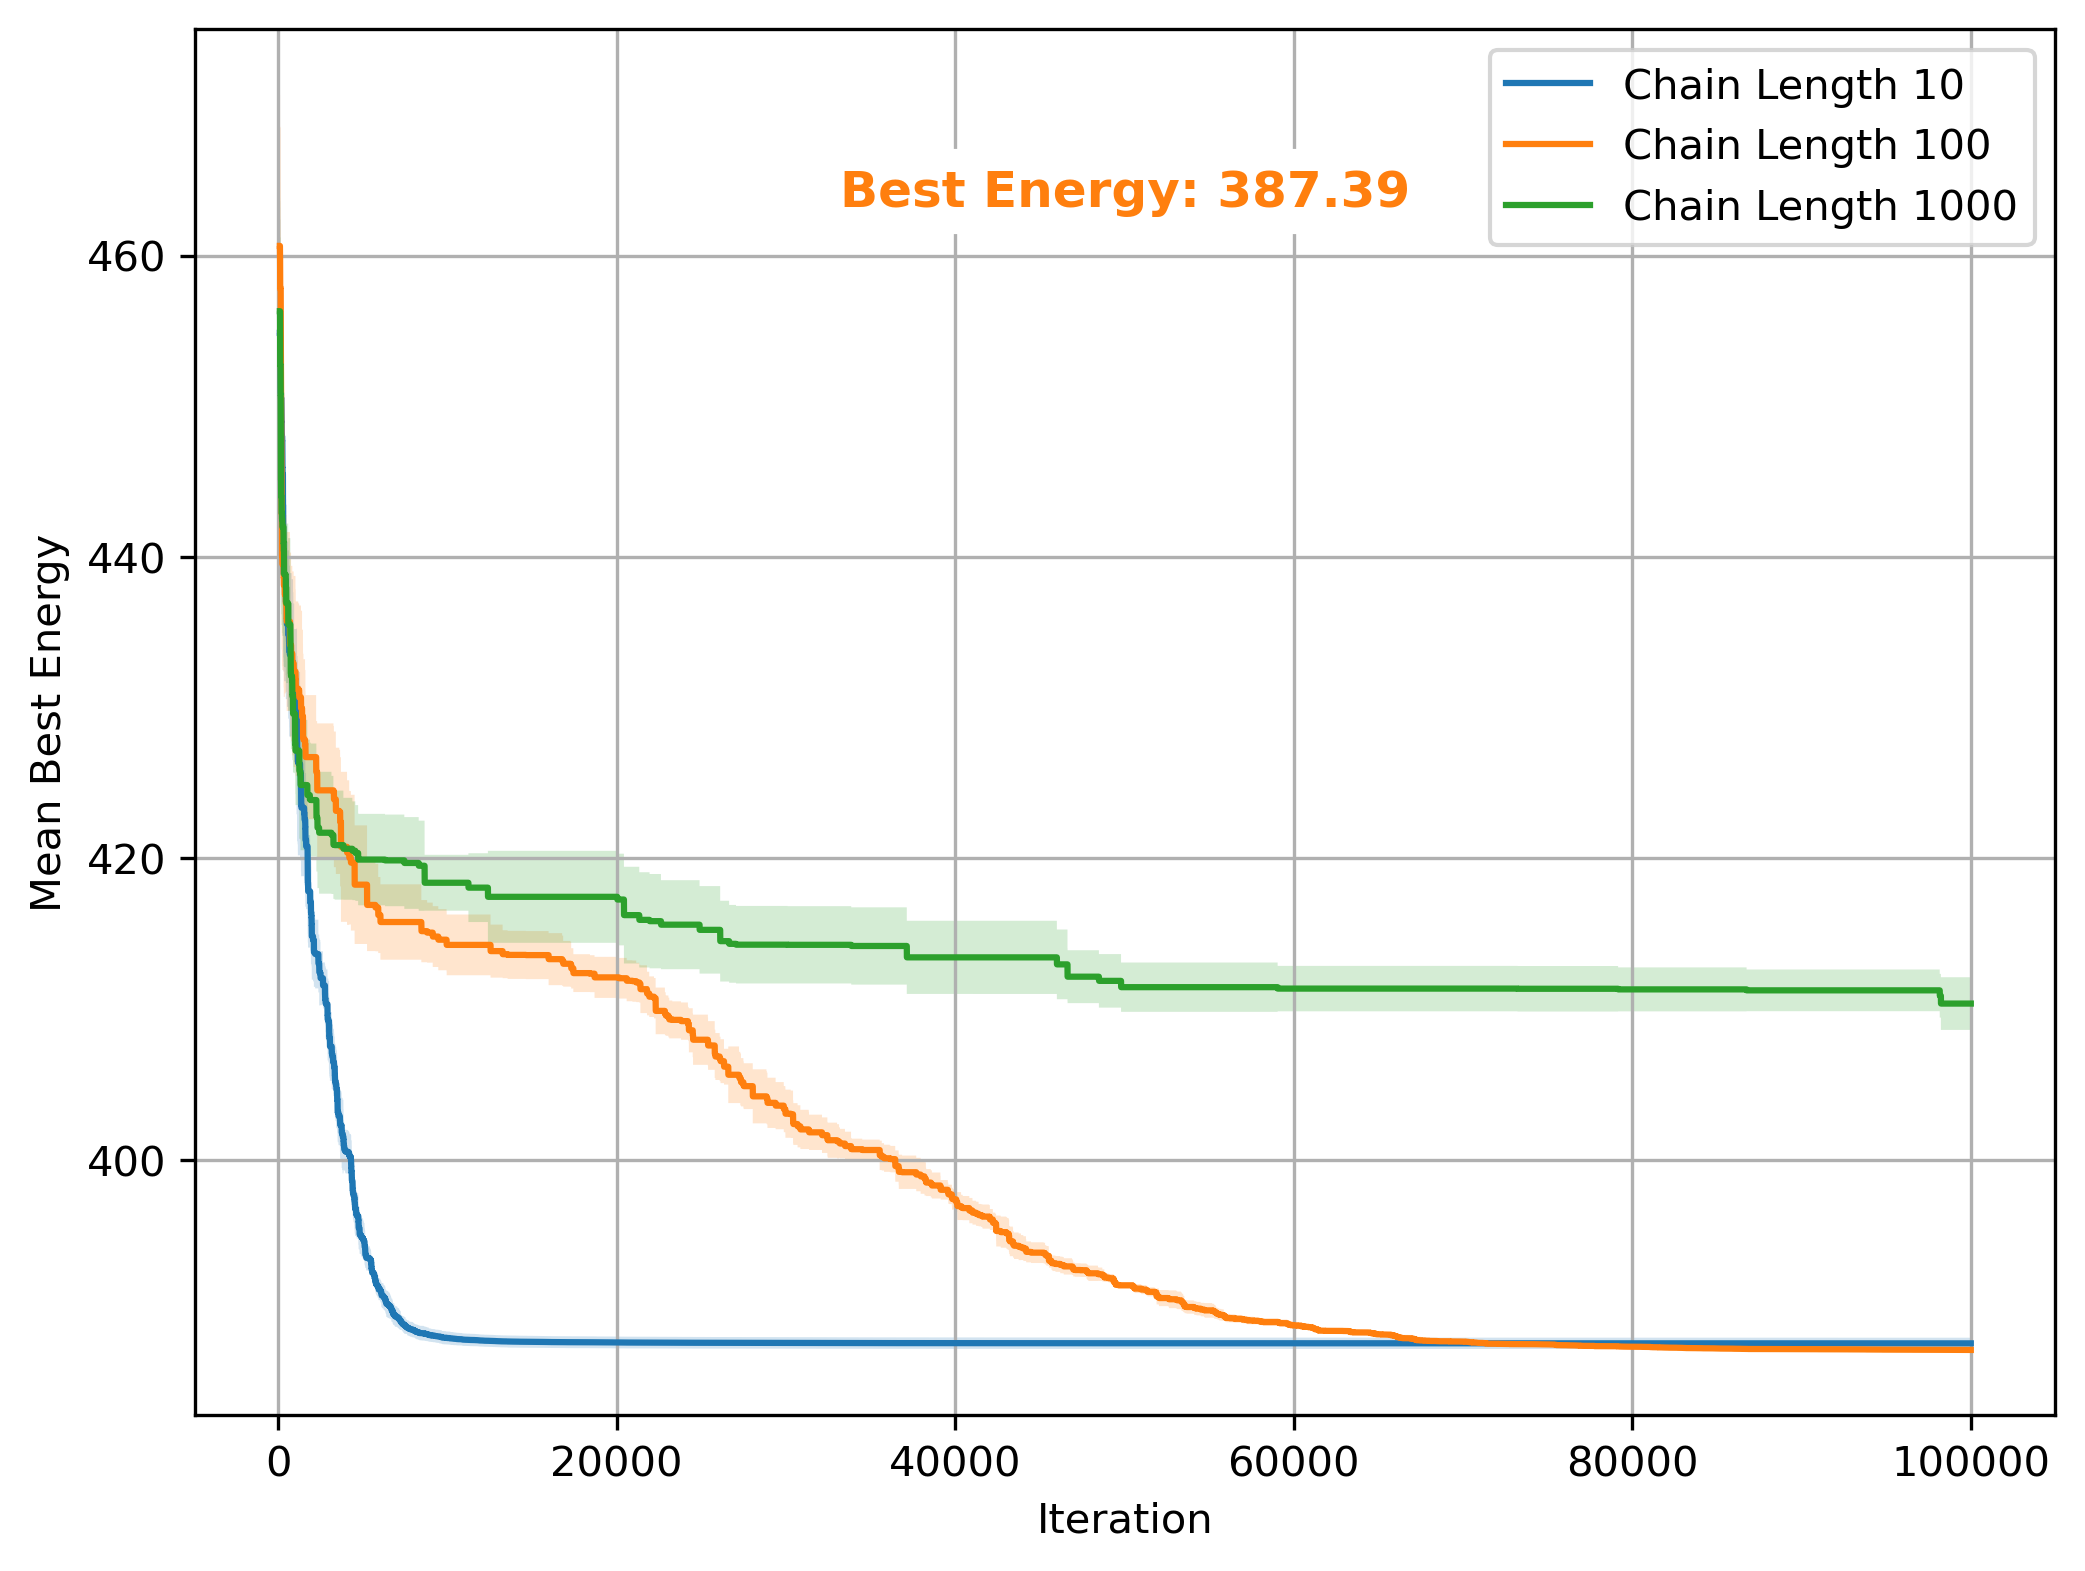

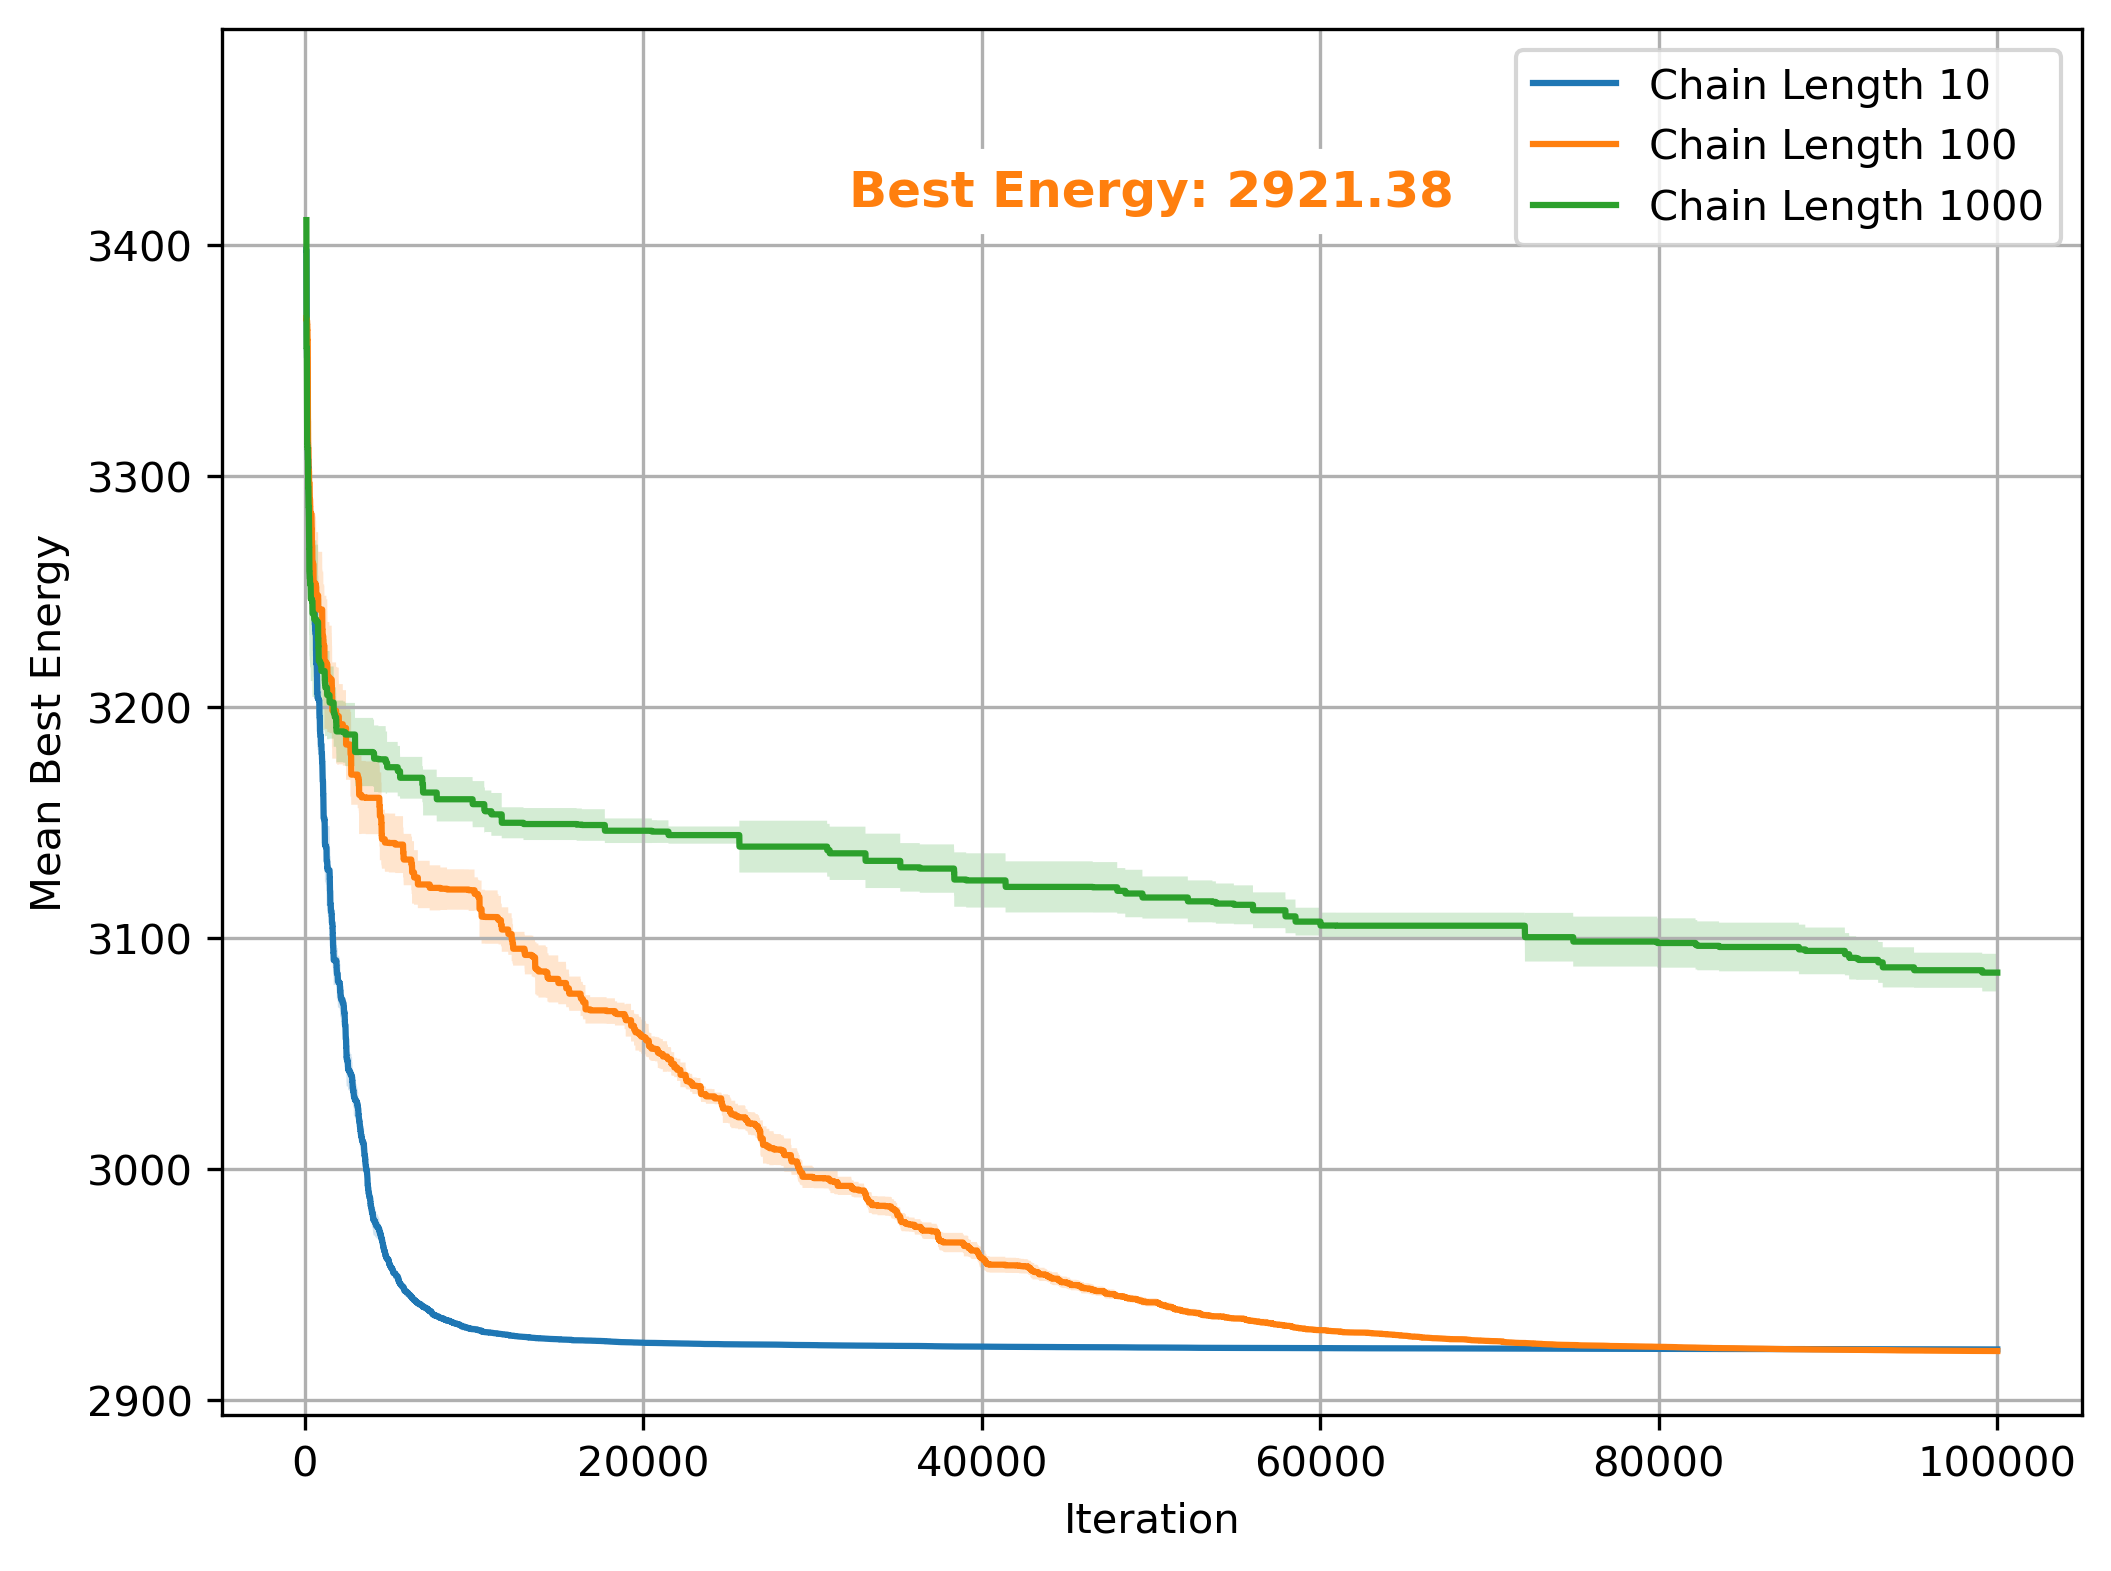

In [12]:
mean_best_energies = {}
confidence_intervals = {}

for n in n_particles:
    final_best_energies = []
    for chain_length in chain_lengths:
        running_best_energies = []

        energies = results[n][chain_length]['energies']

        for rep in range(repetitions):
            running_best_energies.append(np.minimum.accumulate(energies[rep]))

        running_best_energies = np.array(running_best_energies)
        mean_running_best_energy = np.mean(running_best_energies, axis=0)
        sem_running_best_energy = np.std(running_best_energies, axis=0, ddof=1) / np.sqrt(repetitions)
        
        z_score = norm.ppf(0.975)
        ci = z_score * sem_running_best_energy

        best_energy = mean_running_best_energy[-1]
        final_best_energies.append(best_energy)

        mean_best_energies[chain_length] = mean_running_best_energy
        confidence_intervals[chain_length] = ci
    
    index_best_chain = np.argmin(final_best_energies)
    best_chain = chain_lengths[index_best_chain]

    plt.figure(figsize=(8, 6))

    for chain_length in chain_lengths:
        mean_best_energy = mean_best_energies[chain_length]
        ci = confidence_intervals[chain_length]
        iterations = range(len(mean_best_energy))
        line, = plt.plot(iterations[100:-1], mean_best_energy[100:-1], label=f"Chain Length {chain_length}")
        plt.fill_between(iterations[100:-1], mean_best_energy[100:-1] - ci[100:-1], mean_best_energy[100:-1] + ci[100:-1], alpha=0.2)
        if chain_length == best_chain:
            line_color = line.get_color()

            plt.text(0.5, 0.9, f"Best Energy: {final_best_energies[index_best_chain]:.2f}", ha='center', va='top', transform=plt.gca().transAxes,
                    fontsize=12, color=line_color, fontweight='bold', backgroundcolor='white')

    plt.xlabel("Iteration")
    plt.ylabel("Mean Best Energy")
    plt.legend()
    plt.grid(True)
    plt.show()
